# Like it or not: how to use likelihoods to infer parameters

Question: The number of named hurricanes varies from decade to decade. Is the observed difference real or random?

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['text.usetex'] = True
# NOAA dataset, can be downloaded from Kaggle https://www.kaggle.com/datasets/noaa/hurricane-database?resource=download
df = pd.read_csv('atlantic.csv')
# convert Date to date format
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [107]:
df.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,1851-06-25,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,1851-06-25,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,1851-06-25,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,1851-06-25,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,1851-06-25,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [108]:
# count the number of named hurricanes/TCs during the 1990s
msk = (df['Date'] >= '1990-1-1') & (df['Date'] < '1999-12-31') & (df['Name'] != '            UNNAMED')
df1990 = df.loc[msk]
x1 = len(df1990['Name'].unique())
x1

77

In [109]:
# count the number of named hurricanes/TCs during the 2000s
msk = (df['Date'] >= '2000-1-1') & (df['Date'] < '2009-12-31') & (df['Name'] != '            UNNAMED')
df2000 = df.loc[msk]
x2 = len(df2000['Name'].unique())
x2

117

So we have 77 observed, named hurricances in the 1990s period, and 117 in the 2000s.

To proceed, we build a likelihood function, a function that is proprotional to the probability of observing the data. We need to make assumptions about the problem. Since we're counting events during fixed intervals we'll assume that the counts follow a Poisson distribution

$P(X = x) = \lambda^x e^{-\lambda} / x!$

where $X$ is the random variable (the number of events), $x$ is the observed number of events, $P(X = x)$ is the probability of observing $x$ events and $\lambda$ is the expected number of events.

Assuming that the number of hurricane is an independent from one decade to the next (?), the likelihood function is

$L \propto P(X_1 = x_1) P(X_2 = x_2) \propto \lambda_1^{x_1} e^{-\lambda_1} \lambda_2^{x_2} e^{-\lambda_2}$

Now we're not interested in $\lambda_1, \lambda_2$ individually but instead in $\theta \equiv \lambda_2/\lambda_1$, i.e. the ratio of the expected number of hurricanes and whether this ratio increased or not. 

Hence, we rewrite the likelihood $L$ as
$L \propto \lambda_1^{x_1 + x_2} \theta^{x_2} e^{-\lambda_1 (1 + \theta)}$ 

We can eliminate $\lambda_1$ by setting
$\frac{\partial \log(L)}{\partial \lambda_1} = \frac{x_1 + x_2}{\lambda_1} - (1 + \theta) = 0.$
That is, we choose $\lambda_1$ to maximise $L$ (or equivalently $\log(L)$). The parameter value that maximises the likelihood is called the Maximum Likelihood Estimate (MLE in short) and it is customary to denote it with a $\hat{}$. Here, we get

$\hat{\lambda_1} = \frac{x_1 + x_2}{1 + \theta}.$

Plugging this expression into the likelihood gives the (profile) likelihood

$L \propto \theta^{x_2} / (1 + \theta)^{x_1 + x_2}$

which is plotted below


Text(0.5, 0, 'theta')

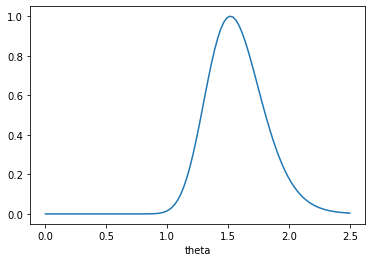

In [110]:
# plot the profile likelihood
def Lfunc(theta):
    return theta**x2/(1 + theta)**(x1 + x2)

thetas = np.linspace(0, 2.5, 100)
Ls = Lfunc(thetas)
maxLs = np.amax(Ls)
fig, ax = plt.subplots()
ax.plot(thetas, Ls/maxLs)
ax.set_xlabel('theta')

We observe that the most likely ratio $\theta$ must be around 1.5 ($x_2/x_1 = 1.52$), which is not too surprising.

More importantly, we can estimate the probability that $\theta = 1$ from $L(1)/L(\hat{\theta}) = 0.016$.

In [111]:
Lfunc(1)/Lfunc(1.52)

0.015710353717836304

We can also estimate the 95% confidence interval

In [112]:
from scipy.optimize import fsolve
def f(t):
    return Lfunc(t)/Lfunc(1.52) - 0.05
lo = fsolve(f, [1.])[0]
hi = fsolve(f, [1.7])[0]
print(f'95% confidence interval is [{lo:.3f}, {hi:.3f}]')

95% confidence interval is [1.065, 2.188]


Text(0.5, 0, 'theta')

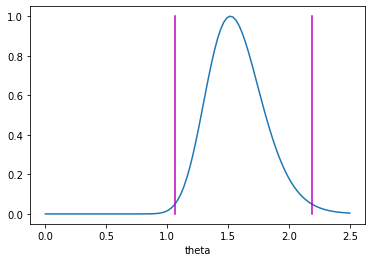

In [113]:
fig, ax = plt.subplots()
ax.plot(thetas, Ls/maxLs)
ax.plot([lo, lo], [0, 1.], 'm')
ax.plot([hi, hi], [0, 1.], 'm')
ax.set_xlabel('theta')

It is often more convenient to work with the $\log$ of the likelihood

$\ell \equiv \log L = x_2 \log \theta - (x_1 + x_2) \log (1 + \theta)$

The MLEs of $\ell$ and $L$ are the same since $\log$ is a monotonically increasing function. Working with $\ell$ is easier when we taking derivatives. Specifically, 

$\frac{\partial \ell}{\partial \theta} = \frac{x_2}{\theta} - \frac{x_1 + x_2}{1 + \theta}$

from which we find $\hat{\theta} = x_2/x_1$.

/var/folders/9n/xdj7z1gd3ps96j4nqzgkfd1h0000gq/T/ipykernel_21884/609149604.py:2: RuntimeWarning: divide by zero encountered in log
  return x2 * np.log(theta) - (x1 + x2) * np.log(1 + theta)


Text(0.5, 0, 'theta')

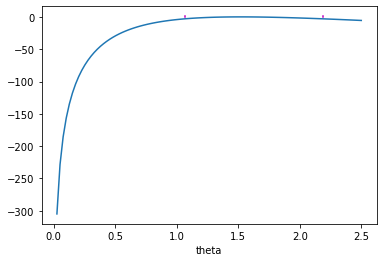

In [114]:
def ellfunc(theta):
    return x2 * np.log(theta) - (x1 + x2) * np.log(1 + theta)

fig, ax = plt.subplots()
ax.plot(thetas, ellfunc(thetas) - np.log(maxLs))
ax.plot([lo, lo], [0, 1.], 'm')
ax.plot([hi, hi], [0, 1.], 'm')
ax.set_xlabel('theta')

Another way to estimate the confidence interval is based on

$\ell(\theta) \approx \ell(\hat{\theta)}) - \frac{1}{2} I(\hat{\theta}) (\theta - \hat{\theta})$

with 

$I = -\frac{\partial^2 \ell}{\partial \theta^2} =  \frac{x_1^3}{x_2 (x_1 + x_2)}$

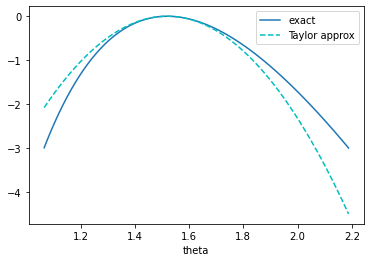

In [115]:
thetas = np.linspace(1.065, 2.188, 100)
fig, ax = plt.subplots()
ax.plot(thetas, ellfunc(thetas) - np.log(maxLs))
ax.plot(thetas, - 0.5 * x1**3/(x2*(x1+x2)) *(thetas - x2/x1)**2, 'c--')
ax.set_xlabel('theta')
ax.legend(['exact', 'Taylor approx'])

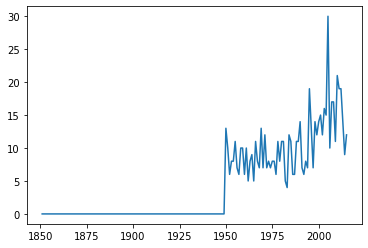

In [139]:
# look at the number of named cyclones over the years
names = df['Name'].unique()
min_year = df['Date'].dt.year.min()
max_year = df['Date'].dt.year.max()
years = np.array(range(min_year, max_year + 1))
counts = np.zeros_like(years)
for name in names:
    if name == '            UNNAMED':
        # skip
        continue
    df_name = df[ df['Name'] == name ]
    name_appears_in_years = df_name['Date'].dt.year.unique()
    for y in name_appears_in_years:
        counts[y - min_year] += 1

plt.plot(years, counts)



In [141]:
start_year = 1950 
years_1950 = years[start_year-min_year:]
counts_1950 = counts[start_year-min_year:]
print(min_year)

1851


In [147]:
# create a covariate y = year and determine how the number of named cyclones increases over the years, starting from 1951
data = {'years': years_1950, 'counts': counts_1950}
data


{'years': array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
        1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
        1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
        1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
        1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
        2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]),
 'counts': array([13, 10,  6,  8,  8, 11,  7,  6, 10, 10,  6, 10,  5,  8,  9,  5, 11,
         8,  7, 13,  7, 12,  7,  8,  7,  8,  8,  6, 11,  8, 11, 11,  5,  4,
        12, 11,  6,  6, 11, 11, 14,  7,  6,  8,  7, 19, 13,  7, 14, 12, 14,
        15, 12, 16, 15, 30, 10, 17, 17, 11, 21, 19, 19, 14,  9, 12])}

In [163]:
from scipy.optimize import minimize
ys = np.array(data['years'], np.float64)
cs = np.array(data['counts'], np.float64)

def minusLogL(params):
    lams = np.exp(params[0]*(ys - start_year)/100.)
    return np.sum(-cs*np.log(lams) + lams) # negative since we minimise

method = 'L-BFGS-B' # 'SLSQP' # 'TNC' # 'L-BFGS-B'
res = minimize(minusLogL, x0=[0.0], method=method, tol=1.e-10, options={'maxiter': 1000})
res



      fun: -783.6754726235714
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([3.31786436])